In [ ]:

import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
load_dotenv()

def get_model(model: str = 'deepseek-r1:7b', provider: str = 'local'):
    if (provider == 'local'):
        from langchain_ollama import ChatOllama
        llm = ChatOllama(model=model, temperature=0)
        return llm
    elif (provider == 'aws'):
        from langchain_aws import ChatBedrockConverse
        import boto3
        access_key = os.getenv('ACCESS_KEY')
        secret_key = os.getenv('SECRET_KEY')
        bedrock_client = boto3.client('bedrock-runtime',
                                      region_name='us-east-1',
                                      aws_access_key_id=access_key,
                                      aws_secret_access_key=secret_key)
        llm = ChatBedrockConverse(client=bedrock_client,
                                  model=model,
                                  temperature=0)
        return llm

def get_embeddings(model:str='deepseek-r1:7b', provider:str='local'):
    if(provider == 'local'):
        from langchain_ollama import OllamaEmbeddings
        embeddings=OllamaEmbeddings(model=model)
        return embeddings
    elif(provider == 'aws'):
        from langchain_aws import BedrockEmbeddings
        import boto3
        access_key=os.getenv('ACCESS_KEY')
        secret_key=os.getenv('SECRET_KEY')
        bedrock_client=boto3.client('bedrock-runtime', region_name='us-east-1', aws_access_key_id=access_key, aws_secret_access_key=secret_key)
        embeddings=BedrockEmbeddings(client=bedrock_client, model_id=model)
        return embeddings

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [5]:
from llama_cloud_services import LlamaParse

parser = LlamaParse(api_key=os.getenv("LAMA_PARSE_API_KEY"),parse_mode="parse_page_with_layout_agent")

In [9]:
parsed_pdf = parser.get_json_result("./data/llamaparsetest.pdf")

Started parsing the file under job_id 9a3b2b18-dd2d-4e3e-b4c4-b5b41852d2c3


In [10]:
import pypickle

import pypickle
filepath = './data/parsetest.pkl'

# Save
status = pypickle.save(filepath, parsed_pdf)

11-04-25 00:36:28 [pypickle.pypickle] > INFO     > Pickle file saved: ./data/parsetest.pkl


In [11]:

from llama_index.core import Document

pages = parsed_pdf[0]["pages"]
documents = []

for i, page in enumerate(pages):
    # loop trough items of the page
    for item in page["items"]:
        document = Document(
            text=item["md"], extra_info={"bbox": item["bBox"], "page": i}
        )
        documents.append(document)

In [14]:
print(pages)

[{'page': 1, 'text': '                    Pricing\n                                        Credits\n Category        Mode        Model        per\n                                          Page\nStandard\nParsing       Fast          -           1\nModes\n              Balanced      -           3\n              (default)\n              Premium       -           45\nAdvanced      Parse\nParsing       without AI    -           1\nModes\n              Parse with    -           3\n              LLM\n              Parse with    gemini-2.\n              LVM           0-          6\n                            flash-001\n              Parse with    openai-     30\n              LVM           gpt4o\n              Parse with    anthropic\n              LVM           -sonnet-3   60\n                            .5\n              Parse with    anthropic\n              LVM           -sonnet-3   60\n                            .7', 'md': '# Pricing\n\n|Category|Mode|Model|Credits\nper\nPage|\n|---|--

In [16]:
from llama_index.core.schema import TextNode
from typing import List
def get_text_nodes(json_list: List[dict]):
    text_nodes = []
    for idx, page in enumerate(json_list):
        text_node = TextNode(text=page["md"], metadata={"page": page["page"]})
        text_nodes.append(text_node)
    return text_nodes

In [17]:
text=get_text_nodes(pages)

In [27]:
print(text[3].text)

# Limitations

LlamaParse have the following limitations:

- Maximum run time for jobs : 30 minutes. If your job take more than 30 minutes to process, a TIMEOUT error will be raised.
- Maximum size of files: 300Mb.
- Maximum image extracted / OCR per page: 35 images. If more images are present in a page, only the 35 biggest one are extracted / OCR.
- Maximum amount of text extracted per page: 64Kb. Content beyond the 64Kb mark is ignored.

## Problem 1.5

The image shows a geometric diagram depicting a point P at the center with four vectors E1, E2, E3, and E4 (shown in blue) emanating from P. There are also four points labeled q1, q2, q3, and q4 connected to P by dashed lines labeled r1ₚ, r2ₚ, r3ₚ, and r4ₚ respectively. The diagram appears to be illustrating a physical or mathematical concept related to vectors and distances in three-dimensional space.

**FIGURE 1.9** Electric field at a point due to a system of charges is the vector sum of the electric fields at the point due to indi

In [29]:
from llama_index.core import Settings

In [40]:
Settings.llm = get_model(provider='aws',model='anthropic.claude-3-sonnet-20240229-v1:0')
Settings.embed_model = get_embeddings(provider='aws',model='amazon.titan-embed-text-v1')

In [42]:
from llama_index.core import VectorStoreIndex

# create an index from the parsed documents
index = VectorStoreIndex.from_documents(documents)

In [43]:

from llama_index.core.query_engine import CitationQueryEngine

query_engine = CitationQueryEngine.from_args(index, similarity_top_k=3)

In [44]:
response = query_engine.query(
    "How many credits per page are used for standard parsing modes with balanced mode category?"
)
print(response.response)
     

11-04-25 01:04:32 [langchain_aws.chat_models.bedrock_converse] > INFO     > Using Bedrock Converse API to generate response


According to Source 2, for the Standard Parsing Modes category, the Balanced (default) mode has 3 credits per page [2].


In [45]:

# llm citations are 1 indexed (source 2 -> index 1)
citation = response.source_nodes[1]

# get the visual bbox and the page number of the citation
bbox = citation.node.metadata["bbox"]
page_index = citation.node.metadata["page"]

In [ ]:
import fitz
from PIL import Image

# load page of the pdf
pdf = fitz.open("./data/llamaparsetest.pdf")
page = pdf[page_index]

# take screenshot of the page
pix = page.get_pixmap(dpi=200)
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# resize the page to align the bbox coordinates
parsed_page = pages[page_index]
image = image.resize((parsed_page["width"], parsed_page["height"]))
     

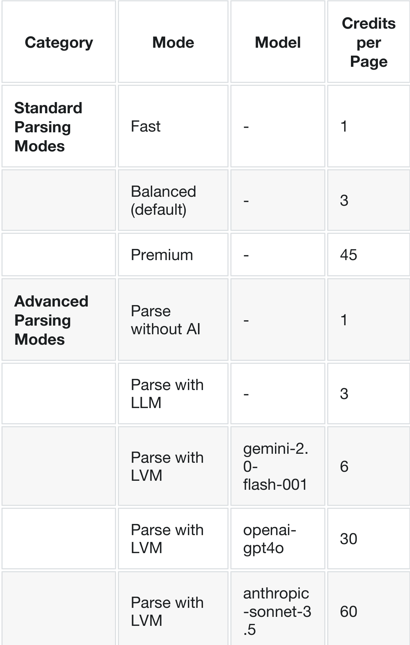

In [49]:
image.crop((bbox["x"], bbox["y"], (bbox["x"] + bbox["w"]), (bbox["y"] + bbox["h"])))